# ========================================
# SUBGROUP 3 — Bankruptcy Prediction
# Cluster ID = 3  (N_total = 44, N_bankrupt = 15)
# ========================================

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import joblib
import os

sns.set(style="whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### Load Cluster Data

In [2]:
df = pd.read_csv("data/train_cluster3.csv")
print(df.shape)
df.head()

(44, 98)


,Index,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,cluster_id
0,323,0,0.479403,0.533635,0.531827,0.603915,0.603771,0.999039,0.797348,0.809266,...,0.042655,0.625532,0.603916,0.839690,0.281775,0.024036,0.573333,1,0.023879,3
1,414,0,0.501194,0.574847,0.555758,0.609695,0.609695,0.999197,0.797668,0.809569,...,0.015047,0.615971,0.609693,0.842432,0.283248,0.026792,0.565164,1,0.021532,3
2,439,0,0.411690,0.455190,0.466834,0.596398,0.596398,0.998906,0.797130,0.809093,...,0.001021,0.623849,0.596398,0.836314,0.279576,0.026726,0.564825,1,0.030008,3
3,747,0,0.533028,0.569560,0.575298,0.608952,0.608952,0.999082,0.797531,0.809427,...,0.004682,0.623778,0.608950,0.841212,0.278585,0.026936,0.565766,1,0.035028,3
4,792,0,0.507434,0.581116,0.562825,0.619359,0.617161,0.999288,0.797749,0.809645,...,0.013497,0.619057,0.619360,0.843815,0.287820,0.026794,0.565174,1,0.017600,3


### Split Features/Target

In [3]:
target_col = "Bankrupt?"

# Drop target, Index, and cluster_id (if present)
drop_cols = ["Bankrupt?", "Index"]
if "cluster_id" in df.columns:
    drop_cols.append("cluster_id")

X = df.drop(columns=drop_cols)
y = df[target_col].astype(int)

print("Original Feature Count:", X.shape[1])

Original Feature Count: 95


In [4]:
rf_fs = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_fs.fit(X, y)

selected_features = (
    pd.Series(rf_fs.feature_importances_, index=X.columns)
    .sort_values(ascending=False)
    .head(25)
    .index.tolist()
)

X = X[selected_features]
print("Selected feature count →", len(selected_features))

Selected feature count → 25


In [5]:
Nfeatures = X.shape[1]
print("\nFinal Nfeatures used =", Nfeatures)
print("\nClass distribution:\n", y.value_counts())


Final Nfeatures used = 25

Class distribution:
 Bankrupt?
0    29
1    15
Name: count, dtype: int64


### Train/Test Split

In [6]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape

((35, 25), (9, 25))

===========================
## Train Multiple Models
===========================

### Evaluation Helper Function

In [7]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    acc_eq1 = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    print(f"\n=== {name} ===")
    print("TN:", tn, "FP:", fp, "FN:", fn, "TP:", tp)
    print("Equation (1) accuracy:", round(acc_eq1, 4))

    return tn, fp, fn, tp, acc_eq1

### Helper: ROC Curve Plot

In [8]:
def plot_roc(models, names, X_test, y_test):
    plt.figure(figsize=(7, 5))

    for model, name in zip(models, names):
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(X_test)[:, 1]
        else:
            # some models only have decision_function
            probs = model.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.3f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison — Subgroup 3")
    plt.legend()
    plt.grid(True)
    plt.show()

### Train Logistic Regression

In [9]:
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        C=0.6,
        random_state=RANDOM_STATE
    )),
])

lr_pipeline.fit(X_train, y_train)
lr_metrics = evaluate_model(lr_pipeline, X_test, y_test, "Logistic Regression (Subgroup 3)")


=== Logistic Regression (Subgroup 3) ===
TN: 4 FP: 2 FN: 1 TP: 2
Equation (1) accuracy: 0.6667


### Train Random Forest

In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",
    random_state=RANDOM_STATE,
)

rf.fit(X_train, y_train)
rf_metrics = evaluate_model(rf, X_test, y_test, "Random Forest (Subgroup 3)")


=== Random Forest (Subgroup 3) ===
TN: 4 FP: 2 FN: 0 TP: 3
Equation (1) accuracy: 1.0


### Train Gradient Boosting

In [11]:
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=150,
    max_depth=2,
    random_state=RANDOM_STATE,
)

gb.fit(X_train, y_train)
gb_metrics = evaluate_model(gb, X_test, y_test, "Gradient Boosting (Subgroup 3)")


=== Gradient Boosting (Subgroup 3) ===
TN: 4 FP: 2 FN: 0 TP: 3
Equation (1) accuracy: 1.0


#### Support Vector Machine (RBF, scaled)

In [12]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        C=0.6,
        gamma="scale",
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

svm_pipeline.fit(X_train, y_train)
svm_metrics = evaluate_model(svm_pipeline, X_test, y_test, "SVM RBF (Subgroup 3)")


=== SVM RBF (Subgroup 3) ===
TN: 4 FP: 2 FN: 2 TP: 1
Equation (1) accuracy: 0.3333


### Train KNN

In [13]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=7)),
])

knn_pipeline.fit(X_train, y_train)
knn_metrics = evaluate_model(knn_pipeline, X_test, y_test, "KNN (Subgroup 3)")


=== KNN (Subgroup 3) ===
TN: 5 FP: 1 FN: 1 TP: 2
Equation (1) accuracy: 0.6667


### ROC Curve Comparison for some base models

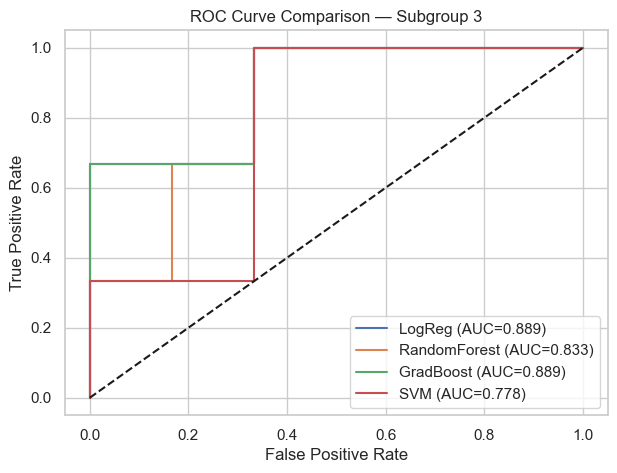

In [14]:
plot_roc(
    models=[lr_pipeline, rf, gb, svm_pipeline],
    names=["LogReg", "RandomForest", "GradBoost", "SVM"],
    X_test=X_test,
    y_test=y_test
)

================================
## Stacking Model
================================

### Build Stacking Model

In [15]:
base_estimators = [
    ("lr", lr_pipeline),
    ("rf", rf),
    ("gb", gb),
]

# final estimator on top of base models
final_est = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    C=0.35,
    random_state=RANDOM_STATE
)

stack_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

stack_model.fit(X_train, y_train)
stack_metrics = evaluate_model(stack_model, X_test, y_test, "STACKING MODEL (Subgroup 3)")


=== STACKING MODEL (Subgroup 3) ===
TN: 4 FP: 2 FN: 1 TP: 2
Equation (1) accuracy: 0.6667


### Confusion Matrix Heatmap — Stacking Model

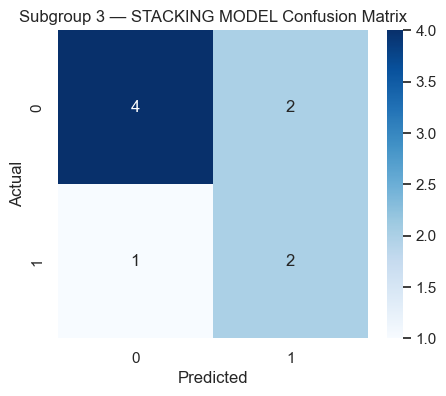

In [16]:
def plot_confusion(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(
    stack_model,
    X_test,
    y_test,
    "Subgroup 3 — STACKING MODEL Confusion Matrix"
)

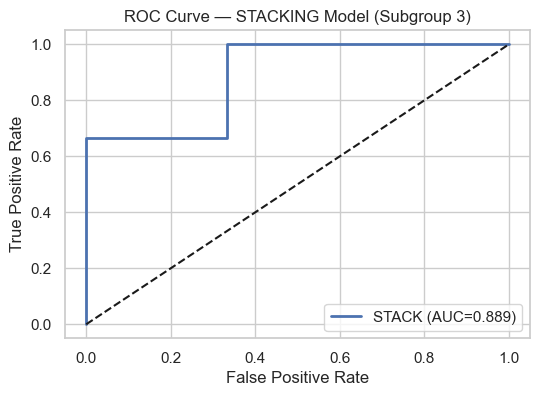

In [17]:
# ================= ROC for STACK ONLY =================
from sklearn.metrics import roc_curve, auc

probs = stack_model.predict_proba(X_test)[:,1]
fpr,tpr,_ = roc_curve(y_test, probs)
auc_val = auc(fpr,tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,label=f"STACK (AUC={auc_val:.3f})",linewidth=2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — STACKING Model (Subgroup 3)")
plt.legend()
plt.grid(True)
plt.show()


### Save Stacking model

In [19]:
os.makedirs("models",exist_ok=True)
joblib.dump(stack_model,"models/subgroup3_stacking.joblib")

print("Saved stacking model → models/subgroup3_stacking_model.joblib")

Saved stacking model → models/subgroup3_stacking_model.joblib


### TT/TF Calculation for Table 3

In [20]:
# re-fit stack_model on FULL subgroup data before computing TT/TF
stack_model.fit(X, y)

full_pred = stack_model.predict(X)

TT = int(((y == 1) & (full_pred == 1)).sum())
TF = int(((y == 1) & (full_pred == 0)).sum())
TN = int(((y == 0) & (full_pred == 0)).sum())
FP = int(((y == 0) & (full_pred == 1)).sum())

eq1 = TT / (TT + TF) if (TT + TF) != 0 else 0.0

print("========== SUBGROUP 3 FINAL RESULTS ==========")
print("Total rows:", len(X))
print("Bankrupt companies:", int((y == 1).sum()))
print("----------------------------------------------")
print("TT (Correct bankrupt predictions):", TT)
print("TF (Missed bankrupt predictions):", TF)
print("TN:", TN)
print("FP:", FP)
print("Equation (1) Accuracy:", round(eq1, 4))
print("==============================================")

========== SUBGROUP 3 FINAL RESULTS ==========
Total rows: 44
Bankrupt companies: 15
----------------------------------------------
TT (Correct bankrupt predictions): 15
TF (Missed bankrupt predictions): 0
TN: 27
FP: 2
Equation (1) Accuracy: 1.0


## Summary Table (Combine all metrics)

In [23]:
summary = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Random Forest",
        "Gradient Boosting",
        "STACKING (FINAL)"
    ],
    "TN": [
        lr_metrics[0],
        rf_metrics[0],
        gb_metrics[0],
        stack_metrics[0],
    ],
    "FP": [
        lr_metrics[1],
        rf_metrics[1],
        gb_metrics[1],
        stack_metrics[1],
    ],
    "FN": [
        lr_metrics[2],
        rf_metrics[2],
        gb_metrics[2],
        stack_metrics[2],
    ],
    "TP": [
        lr_metrics[3],
        rf_metrics[3],
        gb_metrics[3],
        stack_metrics[3],
    ],
    "Eq(1)_Accuracy": [
        lr_metrics[4],
        rf_metrics[4],
        gb_metrics[4],
        stack_metrics[4],
    ],
})

summary

,Model,TN,FP,FN,TP,Eq(1)_Accuracy
0,Logistic Regression,4,2,1,2,0.666667
1,Random Forest,4,2,0,3,1.000000
2,Gradient Boosting,4,2,0,3,1.000000
3,STACKING (FINAL),4,2,1,2,0.666667
